In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from umap import UMAP
import matplotlib.pyplot as plt
from clustering import *
from hdbscan import HDBSCAN
import joblib
from ipywidgets import interact, IntSlider, Dropdown
from functools import partial
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df = pd.read_csv(data_tot)

corpus = df["cleaned_corpus"].tolist()
custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

corpus_cleaned = [delete_stopwords(text, custom_stopwords) for text in corpus]

https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html#umap

#### **EMBEDDING MODELS**

BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

**allenai-specter**
- Trained specifically on scientific papers using citation-based contrastive learning.
- Captures deep topical similarity — great for patent use cases.
- Input is typically abstracts/full paragraphs, so longer inputs are OK.
- Highly recommended if you’re doing semantic clustering or topic modeling.

https://huggingface.co/spaces/mteb/leaderboard
FOR BEST EMBEDDING MODELS AS OF NOW

In [78]:
embedding_model_allenai = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_allenai = embedding_model_allenai.encode(corpus_cleaned)

joblib.dump(embeddings_allenai, 'embeddings_MiniLM.joblib')

['embeddings_MiniLM.joblib']

#### **DIMENSIONALITY REDUCTION**

An important aspect of BERTopic is the dimensionality reduction of the input embeddings. As embeddings are often high in dimensionality, clustering becomes difficult due to the curse of dimensionality.

A solution is to reduce the dimensionality of the embeddings to a workable dimensional space (e.g., 5) for clustering algorithms to work with. UMAP is used as a default in BERTopic since it can capture both the local and global high-dimensional space in lower dimensions. However, there are other solutions out there, such as PCA that users might be interested in trying out.

NEED TO OPTIMIZE THE PARAMETERS FOR EACH ; could be interesting to look at the proposed solution from : https://medium.com/@boorism/inter-class-clustering-of-text-data-using-dimensionality-reduction-and-bert-390a5f9954b8


##### UMAP

As a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters, we simply define it and pass it to BERTopic:

In [3]:
# Load the embeddings 
embeddings_allenai = joblib.load('embeddings_MiniLM.joblib')

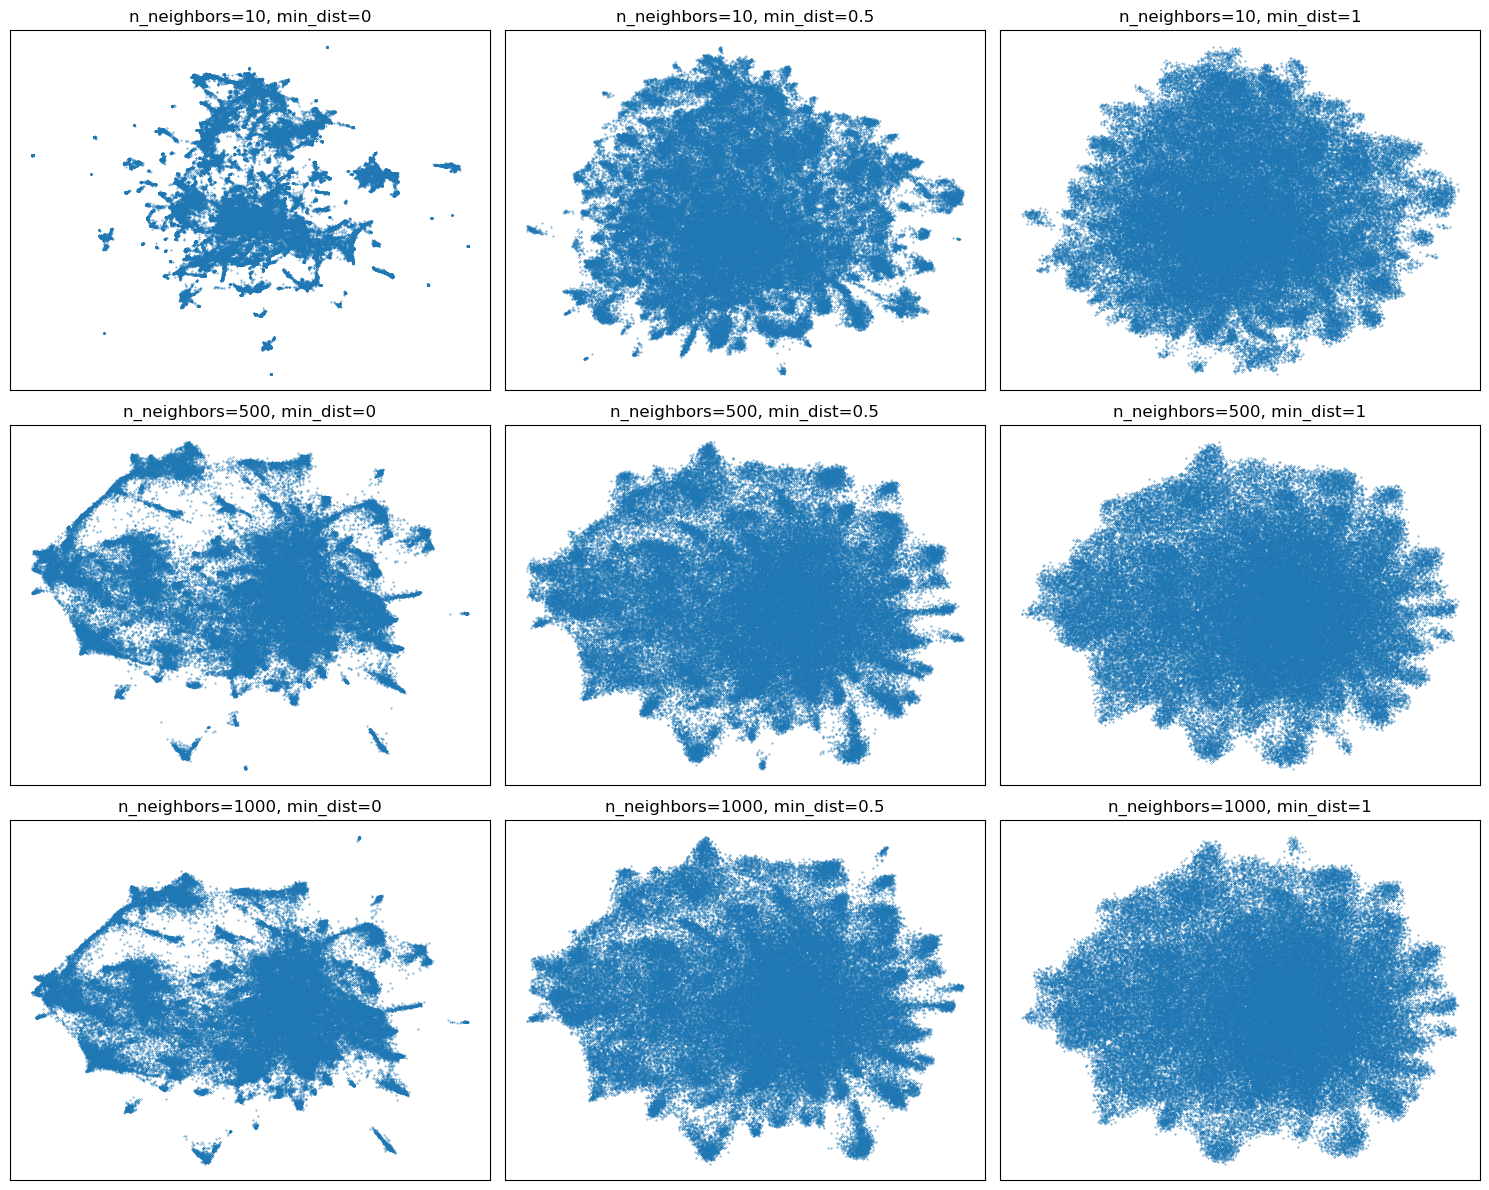

In [4]:
n_neighbors_list = [10, 500, 1000]
min_dist_list = [0, 0.5, 1]

umap_embeddings_dict = {}
umap_models_dict = {}

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        ax = axes[i, j]
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                            n_components=2, random_state=42)
        X_umap = reducer.fit_transform(embeddings_allenai)

        umap_embeddings_dict[(n_neighbors, min_dist)] = X_umap
        umap_models_dict[(n_neighbors, min_dist)] = reducer

        sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In my opinion, there are two combinations which seem pretty good : (500,0) and (10, 0)

['X_umap_10_0.joblib']

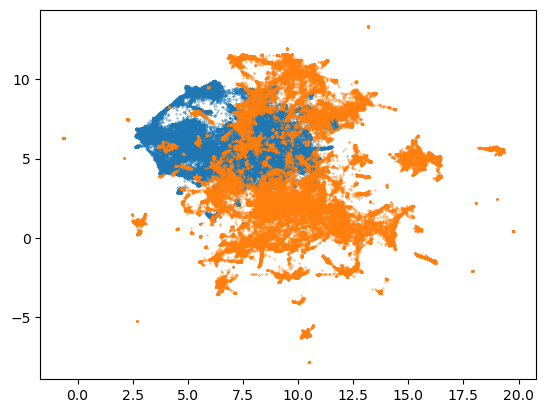

In [5]:
umap_model_500 = umap_models_dict[(500, 0)]
X_umap_500 = umap_embeddings_dict[(500, 0)]
plt.scatter(X_umap_500[:, 0], X_umap_500[:, 1], s=0.1, cmap='Spectral')

joblib.dump(umap_model_500, 'umap_model_500_0.joblib')
joblib.dump(X_umap_500, 'X_umap_500_0.joblib')

umap_model_10 = umap_models_dict[(10, 0)]
X_umap_10 = umap_embeddings_dict[(10, 0)]
plt.scatter(X_umap_10[:, 0], X_umap_10[:, 1], s=0.1, cmap='Spectral')

joblib.dump(umap_model_10, 'umap_model_10_0.joblib')
joblib.dump(X_umap_10, 'X_umap_10_0.joblib')

#### **CLUSTERING**

After reducing the dimensionality of our input embeddings, we need to cluster them into groups of similar embeddings to extract our topics. This process of clustering is quite important because the more performant our clustering technique the more accurate our topic representations are.

In BERTopic, we typically use HDBSCAN as it is quite capable of capturing structures with different densities. However, there is not one perfect clustering model and you might want to be using something entirely different for your use case.

##### HDBSCAN

As a default, BERTopic uses HDBSCAN to perform its clustering. To use a HDBSCAN model with custom parameters, we simply define it and pass it to BERTopic:

ONCE AGAIN, NEED TO FINETUNE THE PARAMETERS BEFOREHAND

In [6]:
# Load the UMAP coordinates and model 
umap_model = joblib.load('umap_model_500_0.joblib')
X_umap = joblib.load('X_umap_500_0.joblib')

In [7]:
color_map = plt.get_cmap('tab20').colors + plt.get_cmap('tab10').colors
color_map += plt.get_cmap('Set3').colors
color_map = [f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' for r, g, b in color_map]
color_map = color_map[:100]

def compute_hdbscan(min_cluster_sizes, min_samples_list, X_umap):
    hdbscan_labels_dict = {}
    hdbscan_models_dict = {}

    for i, min_cluster_size in enumerate(min_cluster_sizes):
        for j, min_samples in enumerate(min_samples_list):
            clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples)
            labels = clusterer.fit_predict(X_umap)

            hdbscan_labels_dict[(min_cluster_size, min_samples)] = labels
            hdbscan_models_dict[(min_cluster_size, min_samples)] = clusterer
    return hdbscan_labels_dict, hdbscan_models_dict

def plot_hdbscan(labels_dict, min_cluster_size, min_samples):
    labels = labels_dict[(min_cluster_size, min_samples)]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=0.5)
    plt.title(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    plt.xticks([])
    plt.yticks([])
    plt.show()


##### BIG MODELS

In [8]:
# Clusters with big parameters
min_cluster_sizes_big = [500, 750, 1000]
min_samples_list_big = [500, 750, 1000]

hdbscan_labels_dict_big, hdbscan_models_dict_big = compute_hdbscan(min_cluster_sizes_big, min_samples_list_big, X_umap)

# Clusters with small parameters
min_cluster_sizes_small = [10, 200, 400]
min_samples_list_small = [10, 200, 400]

hdbscan_labels_dict_small, hdbscan_models_dict_small = compute_hdbscan(min_cluster_sizes_small, min_samples_list_small, X_umap)

python(39517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [65]:
from ipywidgets import VBox, HBox, Layout, Checkbox, Output, Label
from IPython.display import display, clear_output
import ipywidgets as widgets

suppress_observers = False

def plot_hdbscan_interactive(labels_dict, min_cluster_size, min_samples):
    labels = labels_dict[(min_cluster_size, min_samples)]
    total_points = len(labels)
    
    # Count noise and cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    n_noise = cluster_counts.get(-1, 0)
    noise_pct = (n_noise / total_points) * 100
    n_clusters = len([k for k in unique if k != -1])
    
    # Assign colors to labels (noise = grey)
    label_color_map = {}
    next_color = 0
    for label in sorted(unique):
        if label == -1:
            label_color_map[label] = 'lightgrey'
        else:
            label_color_map[label] = color_map[next_color % len(color_map)]
            next_color += 1
    colors = [label_color_map[label] for label in labels]

    # Build figure with scatter and bar chart
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
        f"UMAP + HDBSCAN (clusters={n_clusters})",
        "Cluster Size Distribution"
    ))

    # Scatter plot
    hover_text = [f"Cluster: {label}" for label in labels]
    scatter = go.Scattergl(
        x=X_umap[:, 0], y=X_umap[:, 1],
        mode='markers',
        marker=dict(color=colors, size=3),
        text=hover_text,
        hoverinfo='text'
    )
    fig.add_trace(scatter, row=1, col=1)

    # Bar plot of clusters only (exclude noise)
    bar_labels = [label for label in unique if label != -1]
    bar_counts = [cluster_counts[label] for label in bar_labels]
    bar_colors = [label_color_map[label] for label in bar_labels]
    bar = go.Bar(x=[str(label) for label in bar_labels], y=bar_counts, marker_color=bar_colors)
    fig.add_trace(bar, row=1, col=2)

    # Annotate noise info
    fig.add_annotation(
        text=f"Noise (unlabeled) points: {n_noise} ({noise_pct:.1f}%)",
        xref="paper", yref="paper",
        x=0.5, y=1.2, showarrow=False,
        font=dict(size=14)
    )

    # Layout
    fig.update_layout(height=500, width=900, showlegend=False)
    fig.update_xaxes(title_text="UMAP-1", row=1, col=1)
    fig.update_yaxes(title_text="UMAP-2", row=1, col=1)
    fig.update_xaxes(title_text="Cluster Label", row=1, col=2)
    fig.update_yaxes(title_text="Size", row=1, col=2)
    fig.show()

plot_output = Output()

scale_small = Checkbox(value=True, description="small")
scale_big = Checkbox(value=False, description="big")

def get_scale():
    return "small" if scale_small.value else "big"

def enforce_single_check(change):
    if change['name'] == 'value' and change['type'] == 'change':
        if change['owner'] == scale_small and change['new']:
            scale_big.value = False
        elif change['owner'] == scale_big and change['new']:
            scale_small.value = False
        update_plot()

min_cluster_selector = Dropdown(
    options=min_cluster_sizes_small,
    value=min_cluster_sizes_small[0],  
    layout=Layout(width="150px")
)

min_samples_selector = Dropdown(
    options=min_samples_list_small,
    value=min_samples_list_small[0],
    layout=Layout(width="150px")
)

def dropdown_change_handler(change):
    if not suppress_observers and change['name'] == 'value':
        update_plot()

def get_selected_values():
    return min_cluster_selector.value, min_samples_selector.value

def update_plot():
    global suppress_observers
    suppress_observers = True
    scale = get_scale()
    min_cluster_size, min_samples = get_selected_values()

    if scale == "small":
        min_cluster_selector.options = min_cluster_sizes_small
        min_samples_selector.options = min_samples_list_small
        labels_dict = hdbscan_labels_dict_small
    else:
        min_cluster_selector.options = min_cluster_sizes_big
        min_samples_selector.options = min_samples_list_big
        labels_dict = hdbscan_labels_dict_big
    
    suppress_observers = False
    with plot_output:
        clear_output(wait=True)
        plot_hdbscan_interactive(labels_dict, min_cluster_size, min_samples)

min_cluster_selector.observe(dropdown_change_handler, names="value")
min_samples_selector.observe(dropdown_change_handler, names="value")
scale_small.observe(enforce_single_check)
scale_big.observe(enforce_single_check)

param_title = widgets.HTML("<div style='text-align:center; font-size:18px; font-weight:bold; margin-bottom:2px;'>Parameters' Size</div>")
scale_box = HBox([scale_small, scale_big],
                         layout=Layout(justify_content="center", gap="0px"))

# Bottom: Dropdowns right under plot with reduced vertical spacing
cluster_box = VBox([
    widgets.HTML("<div style='margin-bottom:2px; font-size:15px;'>Min Cluster Size</div>"),
    min_cluster_selector
], layout=Layout(align_items="center"))

sample_box = VBox([
    widgets.HTML("<div style='margin-bottom:2px; font-size:15px;'>Min Samples</div>"),
    min_samples_selector
], layout=Layout(align_items="center"))

bottom_row = HBox([cluster_box, sample_box],
                          layout=Layout(justify_content="space-around", padding="5px 20px 0px 25px"))

spacer = widgets.Box(layout=Layout(height='0px'))
# Full UI layout (note reduced spacing between plot and dropdowns)
ui = VBox([
    param_title,
    scale_box,
    spacer,
    plot_output,
    spacer,
    bottom_row
], layout=Layout(width="100%"))

display(ui)
update_plot()

In [10]:
from sklearn.metrics import calinski_harabasz_score
def evaluate_hdbscan_ch(embeddings, min_cluster_sizes, min_samples_list, hdbscan_labels_dict):
    scores = np.zeros((len(min_cluster_sizes), len(min_samples_list)))

    for i, min_cluster_size in enumerate(min_cluster_sizes):
        for j, min_samples in enumerate(min_samples_list):

            labels = hdbscan_labels_dict.get((min_cluster_size, min_samples))

            if labels is None:
                scores[i, j] = 0
                continue

            mask = labels != -1
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if np.sum(mask) > 1 and n_clusters > 1:
                score = calinski_harabasz_score(embeddings[mask], labels[mask])
            else:
                score = 0  
            scores[i, j] = score
    return scores

**Calinski-Harabasz Score**
- $n$: total number of samples
- $k$: number of clusters
- $\mu$: overall centroid of the dataset
- $\mu_j$: centroid of cluster j
- $n_j$ : number of points in cluster j
- $x_i$ : data point

**Between-cluster dispersion**
This increases when clusters are far away from each other. 
$$
SS_B = \sum_{j=1}^k n_j||\mu_j - \mu||^2
$$

**Within-cluster dispersion**
This decreases when within cluster data points are close to each other. 
$$
SS_W = \sum_{j=1}^k \sum_{x_i \in C_j} ||x_i - \mu_j||^2
$$

**SCORE**
The optimal CH score is the highest possible. 
$$
CH = \frac{\text{Between-cluster dispersion}}{\text{Within-cluster dispersion}} . \frac{n-k}{k-1}
$$

In [11]:
#import seaborn as sns

# Evaluate scores
#ch_scores = evaluate_hdbscan_ch(X_umap, min_cluster_sizes, min_samples_list, hdbscan_labels_dict)

#plt.figure(figsize=(8, 6))
#sns.heatmap(ch_scores, annot=True, fmt=".1f", cmap="YlGnBu",
            #xticklabels=min_samples_list, yticklabels=min_cluster_sizes)
#plt.xlabel("min_samples")
#plt.ylabel("min_cluster_size")
#plt.title("Calinski-Harabasz Score Heatmap")
#plt.show()

Looking visually at the results it seems clear that the clustering with min_cluster_size of 100 is not optimal. Visually, it seems the best combination is 10, 50 which is kind of confirmed by the obtained score of 1600. 

### C-TFIDF ON CLUSTERS

In [17]:
hdbscan_model_small = hdbscan_models_dict_small[(10,10)]
hdbscan_model_big = hdbscan_models_dict_big[(500,500)]

hdbscan_label_small = hdbscan_labels_dict_small[(10,10)]
hdbscan_label_big = hdbscan_labels_dict_big[(500,500)]

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

def top_words_per_topic(X, terms, top_n=10):
    words_per_topic = []
    for row in X:
        top_indices = row.toarray().flatten().argsort()[::-1][:top_n]
        top_words = [terms[i] for i in top_indices]
        words_per_topic.append(top_words)
    return words_per_topic

def top_words_per_patent(X_tfidf, index, vectorizer, top_n=10):
    row = X_tfidf[index]
    feature_names = np.array(vectorizer.get_feature_names_out())
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return feature_names[top_indices]

def get_topics(data, column):
    data = data[data[column] != -1]

    # Combine texts per cluster
    docs_per_topic = data.groupby(column)['cleaned_corpus'].apply(lambda x: ' '.join(x)).tolist()  
    
    vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
    X_tfidf = vectorizer_tf_idf.fit_transform(docs_per_topic)
    #vectorizer = CountVectorizer(stop_words='english')
    #X_counts = vectorizer.fit_transform(docs_per_topic)

    #transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
    #X_ctfidf = transformer.fit_transform(X_counts)

    # Vocabulary
    terms = vectorizer_tf_idf.get_feature_names_out()
    top_words = top_words_per_topic(X_tfidf, terms, top_n=10)

    dict_topic = {}
    for i, words in enumerate(top_words):
        print(f"Topic {i}: {', '.join(words)}")
        dict_topic[i] = ", ".join(words)
    return dict_topic

def rank_patents_by_membership_strength(df, labels, probabilities, X_tfidf, vectorizer, topics_dict, subtopics_dict):
    copy = df.copy()
    copy["Cluster"] = labels
    copy["MembershipStrength"] = probabilities

    # Add top words per patent
    top_words_all = []
    cluster_top_words = []
    subcluster_topwords = []
    for idx in copy.index:
        cluster = copy.loc[idx, "Cluster"]
        if cluster == -1:
            top_words_all.append("") 
            cluster_top_words.append("")
        else:
            top_words = top_words_per_patent(X_tfidf, idx, vectorizer)
            top_words_all.append(", ".join(top_words))
            cluster_top_words.append(topics_dict.get(cluster, ""))
        subcluster = copy.loc[idx, "Sub-Cluster"]
        if subcluster == -1:
            subcluster_topwords.append("")
        else:
            subcluster_topwords.append(subtopics_dict.get(subcluster, ""))
    
    copy["TopWords"] = top_words_all
    copy["ClusterTopWords"] = cluster_top_words
    copy["SubClusterTopWords"] = subcluster_topwords

    return copy

In [49]:
corpus = df["cleaned_corpus"].dropna().tolist()

custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = vectorizer_tf_idf.fit_transform(corpus_cleaned)

In [50]:
df_copy = df.copy()
df_copy["Cluster"] = hdbscan_label_big
df_copy["Sub-Cluster"] = hdbscan_label_small

topics_dict = get_topics(df_copy, "Cluster")
subtopics_dict = get_topics(df_copy, "Sub-Cluster")
ranked_by_strength_df = rank_patents_by_membership_strength(df_copy, hdbscan_label_big, hdbscan_model_big.probabilities_, X_tfidf, vectorizer_tf_idf, topics_dict, subtopics_dict)
ranked_by_strength_df = ranked_by_strength_df[["patent_id", "Cluster", "Sub-Cluster", "MembershipStrength", "TopWords", "ClusterTopWords", "SubClusterTopWords"]].sort_values(by=["Cluster", "Sub-Cluster", "MembershipStrength"], ascending=[True, True, False])

for cluster_id in ranked_by_strength_df["Cluster"].unique():
    cluster_df = ranked_by_strength_df[ranked_by_strength_df["Cluster"] == cluster_id].head(5)

    print(f"\nCluster {cluster_id}")
    for _, row in cluster_df.iterrows():
        print(f"\nPatent ID: {row['patent_id']}")
        print(f"Membership Strength: {row['MembershipStrength']:.4f}")
        print(f"Top Words: {row['TopWords']}")

ranked_by_strength_df.to_csv("data/bert/topics_hdbscan.csv", index = False)

Topic 0: barrel, cartridge, gun, breech, spring, rear, projectile, forward, breechblock, lever
Topic 1: tire, rim, wheel, member, spoke, felly, hub, plate, spring, tread
Topic 2: bottle, neck, stopper, valve, cap, cork, liquid, machine, tube, member
Topic 3: lens, film, plate, camera, frame, spring, shutter, member, arm, mounted
Topic 4: circuit, contact, switch, current, armature, relay, wire, member, spring, magnet
Topic 5: process, acid, solution, material, water, metal, temperature, mixture, compound, chlorin
Topic 6: valve, pipe, chamber, cylinder, water, air, piston, casing, tube, pressure
Topic 7: rail, track, plate, switch, circuit, lever, contact, signal, tie, member
Topic 8: lever, arm, instrument, sound, record, member, key, valve, spring, shaft
Topic 9: sash, window, frame, member, plate, strip, bar, spring, screen, roller
Topic 10: door, bolt, lock, plate, member, spring, nut, key, lever, arm
Topic 11: mold, plate, wall, member, machine, block, frame, material, metal, shaf

In [51]:
total = ranked_by_strength_df.copy()

membership_strength_df = (
    total
    .groupby(["Cluster", "Sub-Cluster"])["MembershipStrength"]
    .mean()
    .reset_index()
    .rename(columns={"MembershipStrength": "sub-clusterMembershipStrength"})
)

total_merged = pd.merge(
    total,
    membership_strength_df,
    on=["Cluster", "Sub-Cluster"],
    how="left"
)
total_merged

,patent_id,Cluster,Sub-Cluster,MembershipStrength,TopWords,ClusterTopWords,SubClusterTopWords,sub-clusterMembershipStrength
0,613075,-1,-1,0.0,,,,0.0
1,1186073,-1,-1,0.0,,,,0.0
2,1277032,-1,-1,0.0,,,,0.0
3,75691,-1,-1,0.0,,,,0.0
4,1196260,-1,-1,0.0,,,,0.0
...,...,...,...,...,...,...,...,...
99996,153404,18,645,1.0,"cultivator, beam, tongue, plow, axle, evener, ...","shaft, frame, member, arm, machine, lever, pla...","rake, shaft, rakehead, bar, frame, lever, arm,...",1.0
99997,67851,18,645,1.0,"camplate, rake, raking, spindle, reel, platfor...","shaft, frame, member, arm, machine, lever, pla...","rake, shaft, rakehead, bar, frame, lever, arm,...",1.0
99998,194013,18,645,1.0,"clearer, rakehead, teeth, rake, axle, seat, br...","shaft, frame, member, arm, machine, lever, pla...","rake, shaft, rakehead, bar, frame, lever, arm,...",1.0
99999,405517,18,645,1.0,"hoop, staple, slot, stud, roll, diagonal, driv...","shaft, frame, member, arm, machine, lever, pla...","rake, shaft, rakehead, bar, frame, lever, arm,...",1.0


In [64]:
interact_df = total_merged.copy()

interact_df["Count"] = interact_df.groupby(["Cluster", "Sub-Cluster"])["Sub-Cluster"].transform("count")

interact_df["ClusterTotal"] = interact_df.groupby("Cluster")["Sub-Cluster"].transform("count")
interact_df["Percentage"] = 100 * interact_df["Count"] / interact_df["ClusterTotal"]

interact_df["SubClusterTotal"] = interact_df.groupby("Sub-Cluster")["Sub-Cluster"].transform("count")
interact_df["SubClusterPercentage"] = 100 * interact_df["Count"] / interact_df["SubClusterTotal"]

# Dropdown for cluster selection
cluster_dropdown = widgets.Dropdown(
    options=sorted(interact_df["Cluster"].unique()),
    description="Cluster:",
    layout=widgets.Layout(width="200px")
)

# Output widget for plotting
plot_output = widgets.Output()
def update_2_plot(cluster_id):
    with plot_output:
        clear_output(wait=True)
        
        cluster_df = interact_df[interact_df["Cluster"] == cluster_id]
        cluster_words = cluster_df["ClusterTopWords"].iloc[0]

        # Aggregate sub-cluster stats
        sub_df = (
            cluster_df.groupby(["Sub-Cluster", "SubClusterTopWords"], as_index=False)
            .agg({
                "Percentage": "first",
                "SubClusterPercentage": "first",
                "sub-clusterMembershipStrength": "mean"
            })
            .sort_values("Percentage", ascending=False)
        )

        fig = go.Figure()

        fig.add_trace(go.Bar(
            x=sub_df["Sub-Cluster"].astype(str),
            y=sub_df["Percentage"],
            text=sub_df["SubClusterTopWords"],
            customdata=np.stack([
                sub_df["sub-clusterMembershipStrength"].round(3)*100,
                sub_df["SubClusterPercentage"].round(2)
            ], axis=-1),
            hovertemplate=(
                "<b>Sub-Cluster %{x}</b><br>"
                "Percentage: %{y}<br>"
                "Top Words: %{text}<br>"
                "Avg Membership Strength: %{customdata[0]}%<br>"
                "Sub-Cluster Percentage: %{customdata[1]}%<extra></extra>"
            ),
            marker_color="steelblue"
        ))

        fig.update_layout(
            title=dict(
                text=f"Top Words for Cluster {cluster_id}: <b>{cluster_words}</b>",
                x=0.5,
                font=dict(size=16)
            ),
            xaxis_title="Sub-Cluster",
            yaxis_title="Number of Documents",
            height=450,
            margin=dict(t=80)
        )

        fig.show()

widgets.interact(update_2_plot, cluster_id=cluster_dropdown)

# Initial render
display(plot_output)
update_2_plot(cluster_dropdown.value)

interactive(children=(Dropdown(description='Cluster:', layout=Layout(width='200px'), options=(-1, 0, 1, 2, 3, …

Output()